# Classification Summary

The purpose of this notebook is to have a summary on classification. Specifically how to select good metrics for classification tasks, pick the appropiate precision/recall trade-off, compare classifiers, and build good classification systems for a variety of tasks. The Document is sepearated in the following sections:

0. MNIST Dataset (Obtaining data from a classic dataset)
1. Classification Metrics for a Binary Classifier
    1. Confusion Matrix
    2. Precision, Recall, F1 Score
    3. Precision/Recall Trade-Off
        1. PR Curve
        2. ROC Curve and ROC AUC Score
    4. Comparing Binary Classifier Algorithms
2. Multiclass Classification
    1. OvR and OvO strategies
3. Error Analysis
    1. Multiclass Confusion Matrix
    2. Engineering New Features
    3. Analyzing Visual Errors
    4. Centering Images
4. Multilabel Classification
5. Multioutput Classification

**Note:** this project doesn't formally follow a machine learning project checklist (Frame the problem, Get the Data, Explore the Data, Prepare the Data, Shortlist Promising Models, Fine-Tune the System, Present your Solution). Especially on the selection of what machine learning algorithms to use since the purpose is more on a classification system is evaluated than on specific algorithms.



# 0. MNIST Dataset

For this section we will be using the MNIST dataset with 70,000 small images of digits handwritten and the label of the digit they represent.

In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)
print(X.shape, y.shape)
X.head()

(70000, 784) (70000,)


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Label: 5


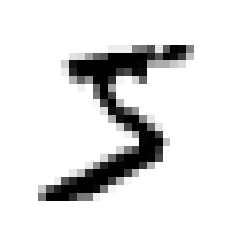

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

X = X.values
five = X[0]
five_image = five.reshape(28,28)
plt.imshow(five_image, cmap=mpl.cm.binary)
plt.axis("off")

print("Label:", y[0])

In [4]:
# The MNIST Database is already split in a train test set
# with similar cross-validation folds.

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 1. Classification Metrics for a Binary Classifier

The purpose of this section is to show different classification metrics to consider on a binnary classifier to evaluate the model. 

In this example our data will be used to detect if a given number is a 5 or not and we will use the model to show different considerations of metrics based on a concrete example. We will use a SGDClassifier first and analize performance.

In [5]:
# we sepparate the dataset as boolean values (True if x=5)
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([five])

array([ True])

## 1.1 Confusion Matrix

For clarity the confusion matrix shows the following values:

| TN | FP | 
| --- | --- |
| **FN** | **TP** |

We will check the performance of our SGDClassifier.

In [6]:
# Instead of Cross Validation Score we get the predicted values
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

# We show a matrix with the labeled and predicted values
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

## 1.2 Precision, Recall, F1 Score

In [7]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print("Precision:", precision_score(y_train_5, y_train_pred))
print("Recall:", recall_score(y_train_5, y_train_pred))
print("F1 Score:", f1_score(y_train_5, y_train_pred))

Precision: 0.8370879772350012
Recall: 0.6511713705958311
F1 Score: 0.7325171197343846


To clarify these results, **precision** is the accuracy of positive predictions, **recall** or true positive rate (TRP) is the ratio of positive instances that are correctly detected by the classifier. **F1 score** is the harmonic mean of precision and recall.

**If you need a simple way to compare between two classifiers, F1 is a very useful tool**. Nevertheless, the F1 score favors classifiers that have similar precision and recall. We do not always want this.

In this example we have much higher precision than recall, if we care little about false negatives (if the model predicts that it is not a 5 but it actually is), then this might be a good metric.

Unfortunatelly there is a **precision/recall trade-off**, that means that increasing precision reduces recall and viceversa.

## 1.3 Precision Recall Trade/Off

Classifiers compute a score based on a desicion function. If that score is greater than a threshold, it assigns the instance to the positive class; otherwise to the negative one.

Since there is a trade off, increasing the threshold will increase precision, but will decrease recall.

There are different factors that should be considered to select the correct threshold. **As a rule of thumb you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives, otherwise use ROC curve**. 

Since we have 5s as positives and not-5s as negatives we clearly have a rare positive class in comparison so we should prefer the PR Curve, we will do anyway on this notebook.

### PR Curve (Precision/Recall Curve) 

We will see what happens if we adjust the threshold to obtain a certain precision.

In [8]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [9]:
# This variable could be changed depending on the model, 
# In this case it is to aim for 90% precision
# Use this line for the Precision vs Recall Graph
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]

print("Threshold at 90% precision:", threshold_90_precision)
print("Recall at 90% precision:", recall_90_precision)

Threshold at 90% precision: 3370.0194991439566
Recall at 90% precision: 0.4799852425751706


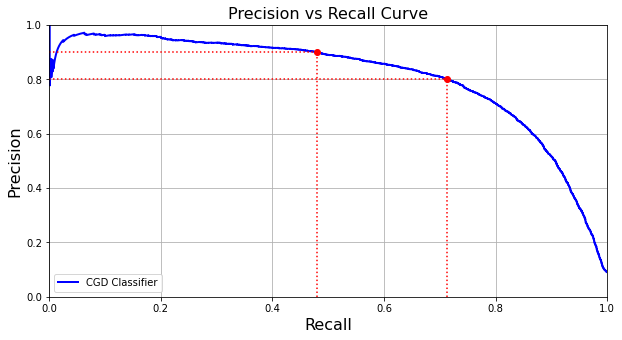

In [10]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2, label="CGD Classifier")
    plt.title("Precision vs Recall Curve", fontsize=16)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

    

# plot for 90%
plt.figure(figsize=(10, 5))
plot_precision_vs_recall(precisions, recalls)
plt.legend(loc="lower left")
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")

# plot for 80%
threshold_80_precision = thresholds[np.argmax(precisions >= 0.80)]
recall_80_precision = recalls[np.argmax(precisions >= 0.80)]
plt.plot([recall_80_precision, recall_80_precision], [0., 0.8], "r:")
plt.plot([0.0, recall_80_precision], [0.8, 0.8], "r:")
plt.plot([recall_80_precision], [0.8], "ro")

plt.show()

We see that in the decaying curve, the precision drops sharply around 80% recall on this graph. 

The threshold choice depends on the project, here you could see if we adjust the precision from 90% to 80% we have a much higher recall without sacrificing much precision, depending on what will be measured and how important False Positives are.

### ROC Curve (Receiver Operating Characteristic)

Similar to the PR curve, this one plots true positive rate (recall) against false positive rate (FPR)

**FPR:** False positive rate is equal to 1- true negative rate = 1 - specificity.

In [11]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

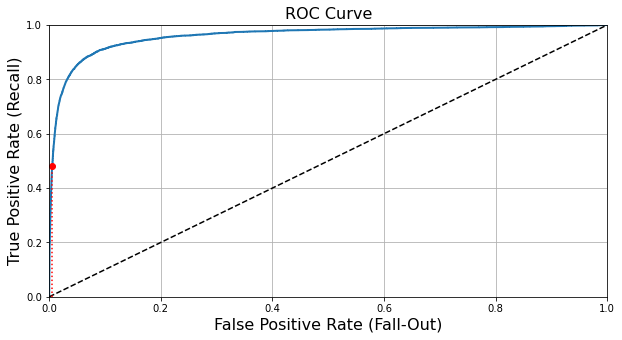

In [12]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.title("ROC Curve", fontsize=16)
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(10, 5))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro") 
plt.show()

A way to compare classifiers is to measure the area under the curve (AUC). A percet classifier will have a ROC AUC equal to 1, a purely random classifier will have a ROC AUC equal to 0.5.

In [13]:
from sklearn.metrics import roc_auc_score

print("ROC AUC Score:", roc_auc_score(y_train_5, y_scores))

ROC AUC Score: 0.9604938554008616


On this scenario we see a very high ROC AUC score, that seems to be a good score, but as we mentioned, in this case there are few positives (5s) in comparison to negatives (not 5s), that will cause this score to be high, reason why we would prefer the PR score on this case.

## 1.4 Comparing Binary Classifier Models

We will now train a Random Forest Classifier and compare ROC and ROC AUC scores.

In [14]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method="predict_proba")

y_scores_forest = y_probas_forest[:,1]

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

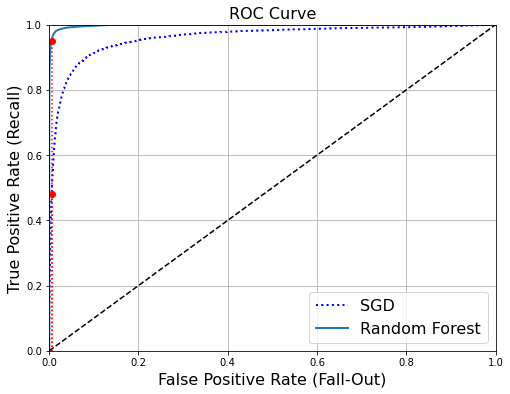

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [16]:
print(roc_auc_score(y_train_5, y_scores), "- SGDClassifier ROC AUC Score")
print(roc_auc_score(y_train_5, y_scores_forest), "- Random Forest Classifier ROC AUC Score:")

0.9604938554008616 - SGDClassifier ROC AUC Score
0.9983436731328145 - Random Forest Classifier ROC AUC Score:


In [17]:
precisions2, recalls2, thresholds2 = precision_recall_curve(y_train_5, y_scores_forest)

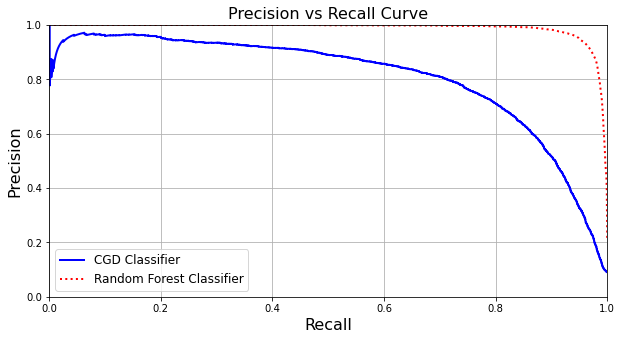

In [18]:
plt.figure(figsize=(10, 5))
plot_precision_vs_recall(precisions, recalls)
plt.plot(recalls2, precisions2, "r:", linewidth=2, label = "Random Forest Classifier")
plt.legend(loc="lower left", fontsize=12)

plt.show()

In [19]:
recall_99_precision = recalls2[np.argmax(precisions2 >= 0.99)]

print("Recall at 99% precision:", recall_99_precision)

Recall at 99% precision: 0.8662608374838591


We observe that for this model the ROC AUC score has improved, but more impresive is when we check the PR curve where we see that at 99% precision we have 86% recall!

# 2. Multiclass Classification

There are different ways to approach multiclass classifiers, some classifiers handle multiple classes natively and others are strictly binary classifiers (that with certain strategies can be used to perform multiclass classificaton with multiple binary classifiers).

- Multinomial Classifiers: SGD Classifiers, Random Forest Classifiers, Naive Bayes Classifiers
- Binomial Classifiers: Logistic Regression, Support Vector Machine Classifiers

For binary classifiers there are 2 common strategies, we will use the number example to show how it could be done.

- **One versus the rest (OvR) strategy:** You train x binary classifiers, one per class (10 in this example 0 to 9 digits). Then you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score.
- **One versus one (OvO) strategy:** You train a classifier in all combination of pairs (Ex. 0 and 1, 0 and 2, ..., 8 and 9) with a total of N x (N-1) / 2 and see wich class wins the most duels.

An advantage of the OvO strategy is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.

Some algorithms (like SVM) scale poorly with the size of the training set, for these algorithms OvO is preferred since its faster to train many classifiers on small training sets than to train few classifiers on large training sets. For most binary classification algorithms, however, OvR is preffered.

**Fortunately, Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and automatically runs one of them depending on the algorithm**.

In [20]:
# example with an SVC
# It will automatically select OvO
# On this scenario it will train 45 binary classifiers, 
# get decision scores and select the class that wins the most duels
# we will scale the values since they vary between 0 and 250
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)

# some_value in this case is a 5
some_value = X[0]
print("Real Value:", y[0])
print("Predicted Value:" ,svm_clf.predict([some_value]))
some_digit_scores = svm_clf.decision_function([some_value])
print("Each Digit Score:")
print(some_digit_scores)
print("All Digits:", svm_clf.classes_)
print("Digit With Max Score:", np.argmax(some_digit_scores))

Real Value: 5
Predicted Value: [5]
Each Digit Score:
[[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]
All Digits: [0 1 2 3 4 5 6 7 8 9]
Digit With Max Score: 5


As we see the first value X0 (that is a five) was accurately predicted, we could observe the matrix of each digits score and that the highest score is 5.

We could still force with Scikit Learn to use one-versus-one or one-versus-the-rest with the OneVsOneClassifier, OneVsRestClassifier on sklearn.multiclass.

**Note:** these predictions are made without feature scaling, cross_validation or using GridSearchCV or RandomSearchCV that will affect results or might cause overfitting, the purpose of the previous code was oriented to display how OvO and OvR work.

# 3. Error Analysis

This section would be used once a promising model already has been found. Tipically we would explore data preparation options, try out multiple models (shortlisting the best ones and fine-tuning their hyperparameters) and automate as much as possible. The following is done assuming that you have found a promising model and want to find ways to improve it.

In [21]:
# Running this promising model that we wish to improve:

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

sgd_clf = SGDClassifier(random_state=42)
#sgd_clf.fit(X_train_scaled, y_train)

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

y_train_pred

array([3, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [22]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

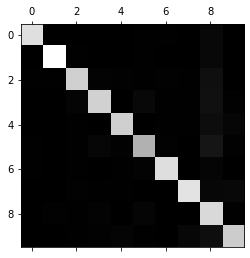

In [23]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

The number 5 is slightly darker meaning that there are less instances of this number or that it doesn't perform as well for this number (both are the case here).

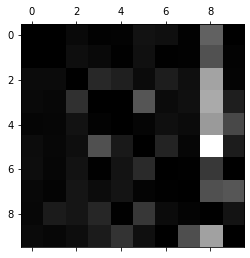

In [24]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

We could observe the type of errors the classifier makes. The column for class 8 is quite bright, this tells you that many images get misclassified as 8s. However the row for class 8 is not that bad, telling you that actual 8s in general get properly classified as 8s. You can also see that 3s and 5s get often confused in both directions.

Analyzing the confusion matrix gives you insights on ways to improve the classifier. On this example, you could try to gather more training data for digits that look like 8s but are not. You could also engineer new features that would help the classifier (Ex. an algorithm to count the number of closed loops (8 has two, 6 has one, 5 has none), you could also preprocess the images to make patters as closed loops stand out more.

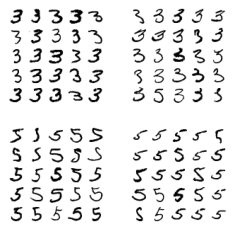

In [25]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(4,4))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

Analyzing individual errors can also be a good way to gain insights on what your classifier is doing and why it is failing, but it is more difficult and time-consuming, an example is plotting 3 and 5s. We see in the following image that the position of the small line that joins the top line to the bottom arc might cause confusion. On this case we used an SGDClassifier that is a linear model that might cause this. One way to reduce the confusion would be to preprocess the images to ensure that they are well centered and not too rotated.

# 4. Multilabel Classification

If you want your classifier to output multiple classes for each instance (as in face recognition if there is more than one person) then you want to output multiple binary tags this is a **multilabel classification system**.

Here we will use a simple example since face recognition should be reviewed on it's own notebook. On this example we se if numbers are large and also if they are odd.

In [26]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

print("Real Value:", y[0])
print("Description: Not Large, Odd [False, True]")
print("Prediction: ", knn_clf.predict([X[0]]))

Real Value: 5
Description: Not Large, Odd [False, True]
Prediction:  [[False  True]]


We see a correct prediction here. An approach to select the right metric is measuring the F1 score for each individual label, then simply compute the average score. The way decided depends on the project, more depth on this will be added on a different notebook.

In [27]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

# 5. Multioutput Classification

A multioutput-multiclass classification is a generalization of multilabel classification where each label can be multiclass. This will be seen further in another notebook.

An example is a system that removes noise from images. Notice that the classifier's output is multilabel (one label per pixel) and each label can have multiple values (0 to 255).

In [28]:
# creating a training and thest set with added random noise

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Image with random noise vs clean


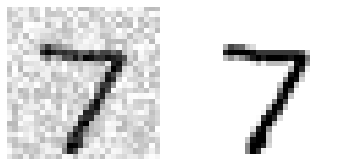

In [30]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

some_index = 0
print("Image with random noise vs clean")
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

digit afer cleaning


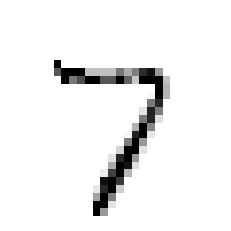

In [31]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
print("digit afer cleaning")
plot_digit(clean_digit)